# Inference: Simple-Importance-Sampling MCMC

The class below takes a posterior and forms another by raising it to a power (1 minus temperature).

In [ ]:
import os
os.chdir("..")
import pints
import pints.toy
import pints.plot
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc

class TemperedLogPosterior(pints.LogPDF):
    def __init__(self, temperature, log_posterior):
        self._temperature = temperature
        self._log_posterior = log_posterior
        
    def __call__(self, x):
        return (1.0 - self._temperature) * self._log_posterior(x)

    def n_parameters(self):
        return self._log_posterior.n_parameters()
def ess(w):
    return int(1.0 / np.sum(w**2))

# Goodwin oscillator

### Untempered

In [6]:
model = pints.toy.GoodwinOscillatorModel()
real_parameters = model.suggested_parameters()
print(real_parameters)
times = model.suggested_times()
values = model.simulate(real_parameters, times)
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.KnownNoiseLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

temperature = 0.0
log_posterior_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_posterior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_max_iterations(5000)
mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

# Get samples
samples=np.vstack(chains)

log_weight = [temperature * log_posterior(sample) for sample in samples]
w = np.exp(log_weight - scipy.misc.logsumexp(log_weight))
print('ESS = ' + str(ess(w)))
idx = np.random.choice(len(w), size=ess(w), p=w)
samples1 = samples[idx, :]

# Look at distribution in chain 0
pints.plot.pairwise(samples1, kde=True)

# Show graphs
plt.show()

[ 2.    4.    0.12  0.08  0.1 ]
Running


KeyboardInterrupt: 

### Tempered at T=0.5

[ 2.    4.    0.12  0.08  0.1 ]
Running
Done!


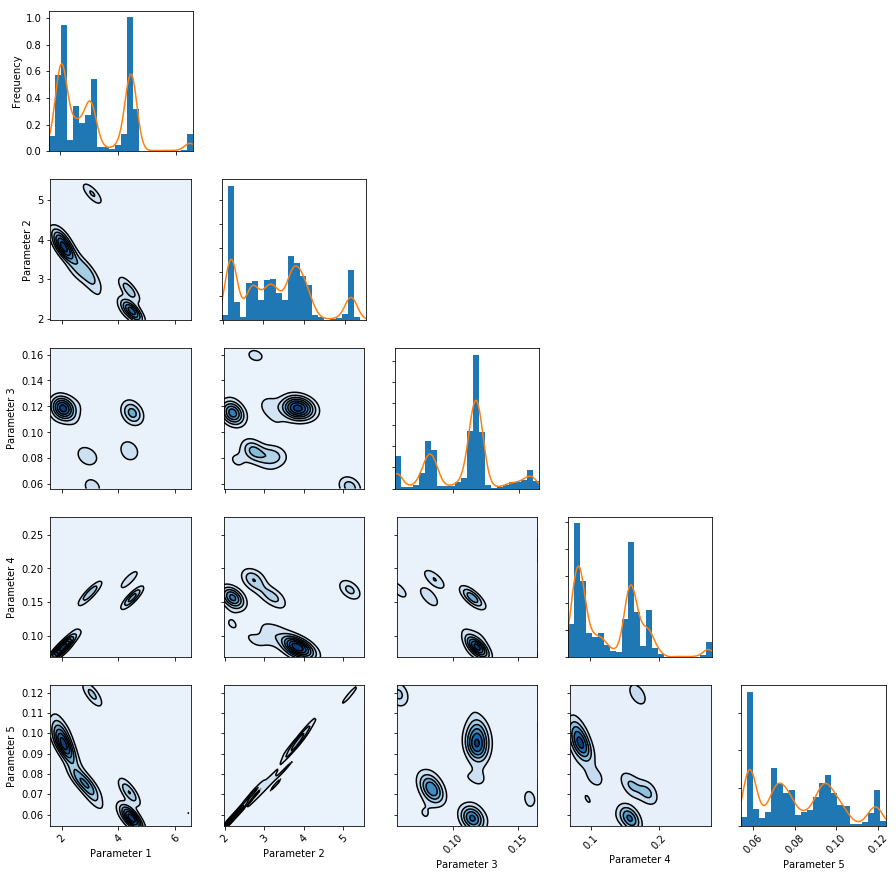

In [4]:
model = pints.toy.GoodwinOscillatorModel()
real_parameters = model.suggested_parameters()
print(real_parameters)
times = model.suggested_times()
values = model.simulate(real_parameters, times)
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.KnownNoiseLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

temperature = 0.0
log_posterior_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_posterior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_max_iterations(5000)
mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

# Discard warm up
chains = chains[:, 2000:, :]

# Get samples
samples=np.vstack(chains)

# Look at distribution in chain 0
pints.plot.pairwise(samples, kde=True)

# Show graphs
plt.show()

## Repressilator

### Untempered

In [9]:
# Create a model
model = pints.toy.RepressilatorModel()

# Run a simulation
parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(parameters, times)

# First add some noise
sigma = 5
noisy = values + np.random.normal(0, sigma, values.shape)

problem = pints.MultiOutputProblem(model, times, noisy)
log_likelihood = pints.KnownNoiseLogLikelihood(problem, sigma)
log_prior = pints.UniformLogPrior([0, 500, 0, 0], [10, 3000, 20, 10])

# Initial guesses
x0 = [
    [2, 800, 3, 3],
    [1, 1200, 6, 1],
    [3, 2000, 1, 4],
]
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
mcmc = pints.MCMCSampling(log_posterior, 3, x0)
mcmc.set_max_iterations(6000)
chains = mcmc.run()

plt.figure()
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

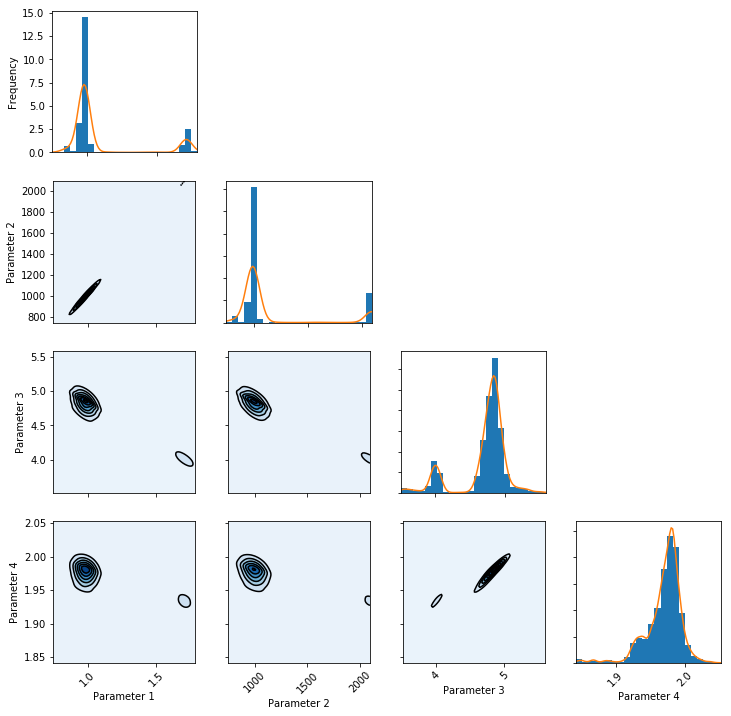

In [11]:
# Discard warm up
chains = chains[:, 2000:, :]

# Get samples
samples=np.vstack(chains)

# Look at distribution in chain 0
pints.plot.pairwise(samples, kde=True)

# Show graphs
plt.show()

### Raised to temperature T=0.5

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0.5        0:00.1
2     9      0         0.333     0.667      0:00.1
3     12     0         0.25      0.5        0:00.2
20    63     0.19      0.286     0.381      0:00.8
40    123    0.146     0.195122  0.293      0:01.5
60    183    0.147541  0.23      0.23       0:02.2
80    243    0.136     0.173     0.198      0:02.9
100   303    0.139     0.178     0.228      0:03.6
120   363    0.149     0.214876  0.198      0:04.1
140   423    0.184     0.191     0.184      0:04.7
160   483    0.168     0.186     0.193      0:05.3
180   543    0.155     0.177     0.182      0:06.0
Initial phase completed.
200   603    0.154     0.159204  0.174      0:06.7
220   663    0.158371  0.145     0.163      0:07.4
240   723    0.17      0.145     0.195      0:08.0
260   783    0.218     0.176

3100  9303   0.216     0.23      0.227991   2:23.2
3120  9363   0.217     0.229     0.229      2:24.4
3140  9423   0.219     0.229     0.23       2:25.5
3160  9483   0.219     0.229     0.231      2:26.7
3180  9543   0.219     0.23      0.231      2:27.8
3200  9603   0.221     0.229     0.233      2:28.9
3220  9663   0.222     0.229     0.234      2:30.1
3240  9723   0.223     0.229     0.236      2:31.2
3260  9783   0.224     0.228     0.238      2:32.3
3280  9843   0.224     0.229808  0.239      2:33.5
3300  9903   0.225     0.231     0.239      2:34.6
3320  9963   0.227     0.231     0.24       2:35.7
3340  10023  0.228     0.231     0.242      2:36.9
3360  10083  0.228     0.23      0.243      2:38.0
3380  10143  0.228     0.23      0.245      2:39.1
3400  10203  0.229     0.23      0.247      2:40.2
3420  10263  0.23      0.23      0.247      2:41.4
3440  10323  0.231     0.23      0.249      2:42.5
3460  10383  0.232     0.231     0.249061   2:43.6
3480  10443  0.232979  0.23    

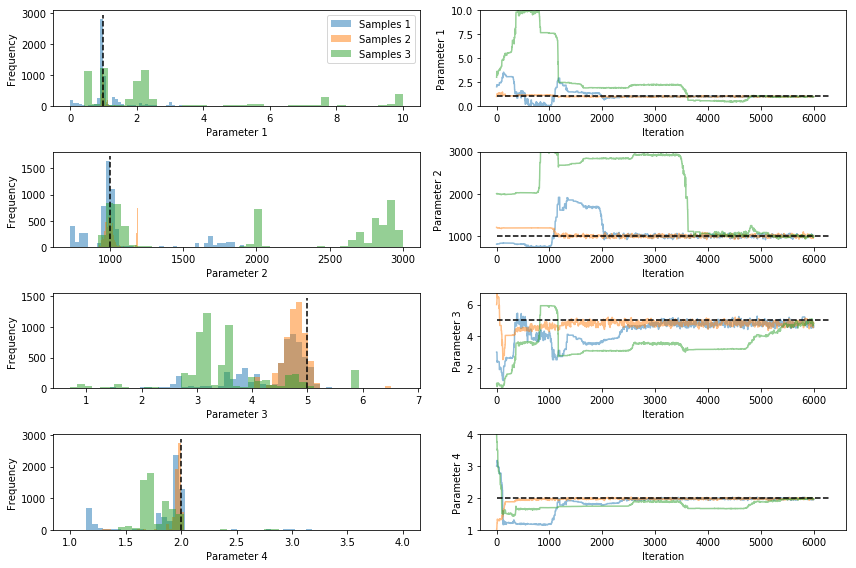

In [12]:
temperature = 0.5
log_posterior_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_posterior)

mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_max_iterations(6000)
chains = mcmc.run()

plt.figure()
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

ESS = 4702


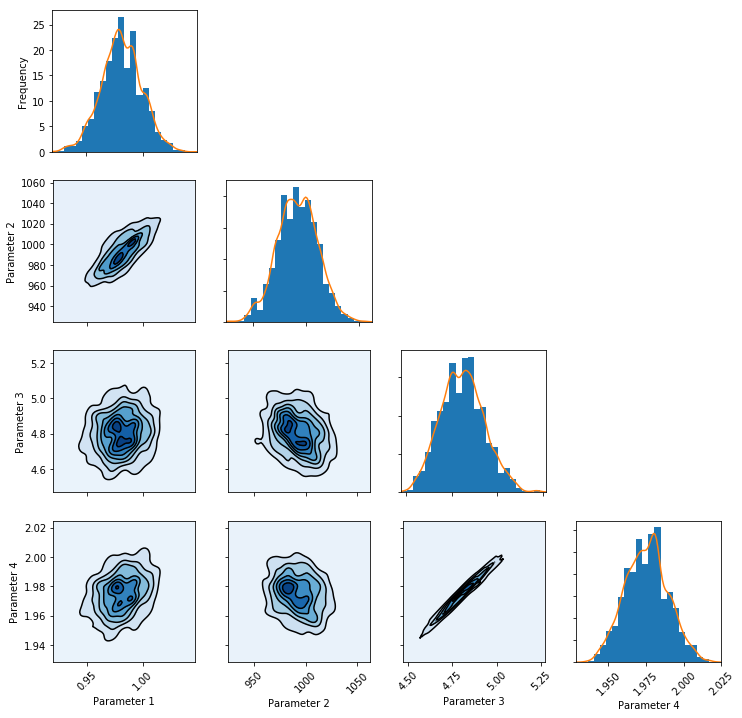

In [13]:
# Discard warm up
chains = chains[:, 2000:, :]

# Get samples
samples=np.vstack(chains)

log_weight = [temperature * log_posterior(sample) for sample in samples]
w = np.exp(log_weight - scipy.misc.logsumexp(log_weight))

print('ESS = ' + str(ess(w)))

idx = np.random.choice(len(w), size=ess(w), p=w)
samples1 = samples[idx, :]

# Look at distribution in chain 0
pints.plot.pairwise(samples1, kde=True)

# Show graphs
plt.show()